# XGBoost #

## INITIAL CONFIGURATION ##

In [1]:
import os
import numpy as np
import pandas as pd
import collections
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from functions_xgboost import *


In [2]:
file_path = (os.path.dirname(os.getcwd()) + '/data/')
data = pd.read_csv(file_path + '/Bank_Customer_Churn_Prediction.csv')

## DATA PROPROCESSING ##

In [3]:
data.drop(columns="customer_id",axis=1,inplace=True)
data['country'] = data['country'].map({'France': 0, 'Spain' : 1,'Germany':2})
data['gender'] = data['gender'].map({'Male': 0, 'Female' : 1})
data['balance'] = data['balance'].astype('int64')
data['estimated_salary'] = data['estimated_salary'].astype('int64')
data.to_csv(file_path+'preprocessed_data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   credit_score      10000 non-null  int64
 1   country           10000 non-null  int64
 2   gender            10000 non-null  int64
 3   age               10000 non-null  int64
 4   tenure            10000 non-null  int64
 5   balance           10000 non-null  int64
 6   products_number   10000 non-null  int64
 7   credit_card       10000 non-null  int64
 8   active_member     10000 non-null  int64
 9   estimated_salary  10000 non-null  int64
 10  churn             10000 non-null  int64
dtypes: int64(11)
memory usage: 859.5 KB


In [5]:
y = data['churn']
X = data.drop(columns='churn', axis = 1)

In [6]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,1,42,2,0,1,1,1,101348
1,608,1,1,41,1,83807,1,0,1,112542
2,502,0,1,42,8,159660,3,1,0,113931
3,699,0,1,39,1,0,2,0,0,93826
4,850,1,1,43,2,125510,1,1,1,79084


In [7]:
np.random.seed(0)
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(collections.Counter(y_resampled).items()))

[(0, 7963), (1, 7963)]


C:\Users\Teresa\AppData\Local\Temp\ipykernel_22196\2992105325.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=dataframe,alpha=0.8,palette='pastel')


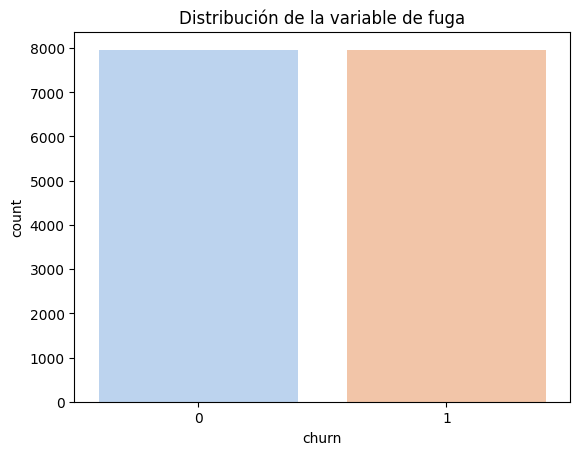

In [8]:
dataframe = pd.DataFrame(y_resampled)
sns.countplot(x='churn', data=dataframe,alpha=0.8,palette='pastel')
plt.title('Distribución de la variable de fuga')
plt.show()

In [9]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [10]:
np.random.seed(0)
sc= StandardScaler()
X_train_rescaled = sc.fit_transform(X_train)
X_test_rescaled = sc.transform(X_test)

In [11]:
print(X_train_rescaled.mean())
print(X_test_rescaled.mean())
print(X_train_rescaled.std())
print(X_test_rescaled.std())

-2.3870666476085e-17
0.01429811034464932
1.0
1.0083331886545412


## MODEL ##

# Fine-tuning #

In [12]:
np.random.seed(0)
### Hyper-parameter tuning with Grid Search method.
param_grid = {'learning_rate' : [0.01, 0.1, 0.3],
              'max_depth': [3,6,9,12],
              'subsample': [0.5,0.75,1],
            }

cv = KFold(n_splits=10, random_state=42, shuffle=True)
clf_model = GridSearchCV(XGBClassifier(random_state=42),param_grid,cv=cv, n_jobs=4, verbose=1)
clf_model = clf_model.fit(X_train_rescaled,y_train)

print ('Acuracy for XGBoost with BEST learning_rate is: {0}, max_depth is : {1}, subsample is: {2}. The success rate is: {3}:'.format(
    clf_model.best_params_['learning_rate'], clf_model.best_params_['max_depth'], clf_model.best_params_['subsample'],clf_model.best_score_))

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Acuracy for XGBoost with BEST learning_rate is: 0.1, max_depth is : 12, subsample is: 0.75. The success rate is: 0.8498430141287285:


In [12]:
np.random.seed(0)
#cross-validation
cv = KFold(n_splits=10, random_state=None, shuffle=True)
train_scores = cross_validate(XGBClassifier(learning_rate=0.1,max_depth=12,subsample=0.75,random_state=42), X_train_rescaled, y_train,cv=cv, scoring=('accuracy', 'precision','recall','f1'),
                        return_train_score=True)

mean_accuracy = train_scores['test_accuracy'].mean()
mean_precision = train_scores['test_precision'].mean()
mean_recall = train_scores['test_recall'].mean()
mean_f1 = train_scores['test_f1'].mean()

print('Mean accuracy:', mean_accuracy)
print('Mean precision:', mean_precision)
print('Mean recall:', mean_recall)
print('Mean F1 score:', mean_f1)

Mean accuracy: 0.8491365777080062
Mean precision: 0.8465427248231583
Mean recall: 0.8551866660699841
Mean F1 score: 0.8507407741124597


In [13]:
np.random.seed(0)
model_xgb = XGBClassifier(learning_rate=0.1,max_depth=12,subsample=0.75,random_state=42)
model_xgb.fit(X_train_rescaled,y_train)
y_pred_test = model_xgb.predict(X_test_rescaled)
y_pred_train = model_xgb.predict(X_train_rescaled)

In [14]:
print('Training Metrics:')
print(f'Training Accuracy: ', accuracy_score(y_train, y_pred_train)) 
print(f'Training Precision: ',precision_score(y_train, y_pred_train))
print(f'Training Recall: ',recall_score(y_train, y_pred_train))
print(f'Training F1-Score: ',f1_score(y_train, y_pred_train))

Training Metrics:
Training Accuracy:  0.9934850863422292
Training Precision:  0.9917612311518732
Training Recall:  0.9953198127925117
Training F1-Score:  0.9935373355135093


In [15]:
print('Testing Metrics:')
print(f'Testing Accuracy: ', accuracy_score(y_test, y_pred_test)) 
print(f'Testing Precision: ',precision_score(y_test, y_pred_test))
print(f'Testing Recall: ',recall_score(y_test, y_pred_test))
print(f'Testing F1-Score: ',f1_score(y_test, y_pred_test))

Testing Metrics:
Testing Accuracy:  0.8581293157564344
Testing Precision:  0.8421379738968303
Testing Recall:  0.8725048293625242
Testing F1-Score:  0.8570524984187223


In [16]:
np.random.seed(0)
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
cnf_matrix = confusion_matrix(y_test, y_pred_test, labels=model_xgb.classes_)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1379  254]
 [ 198 1355]]


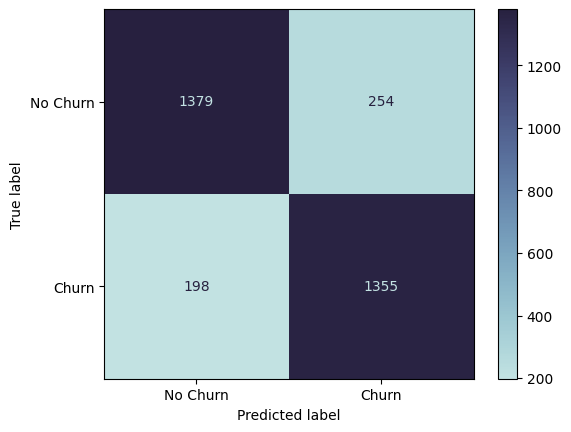

In [17]:
np.random.seed(0)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

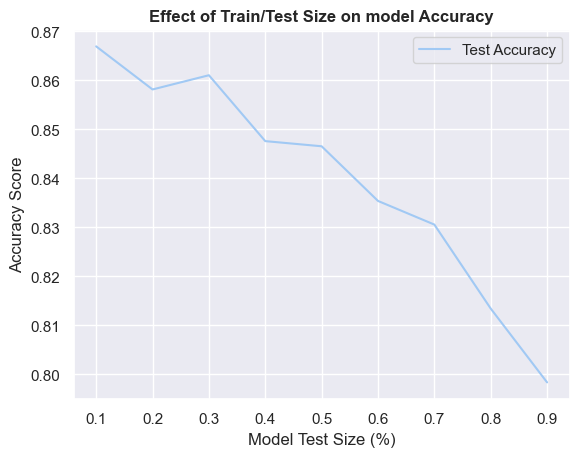

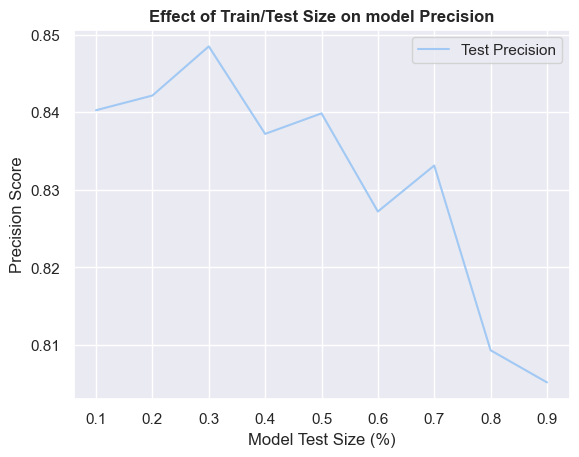

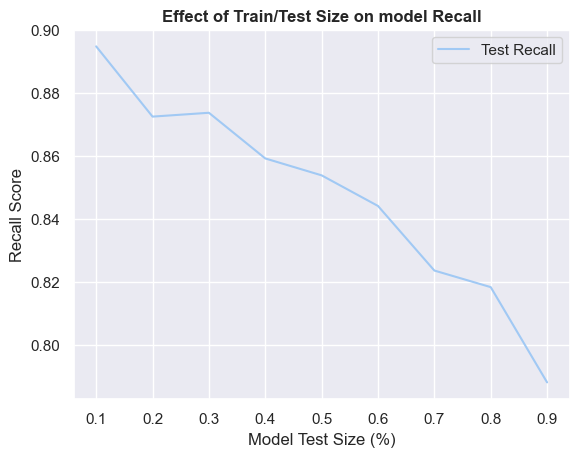

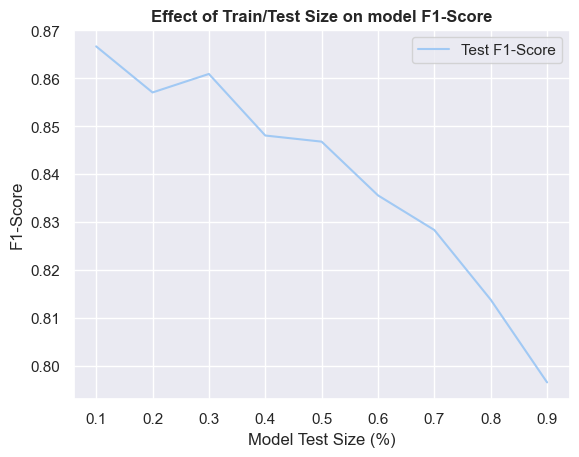

In [18]:
sns.set_theme(style="darkgrid")
print_metric_plots(X_resampled,y_resampled)

c:\TFG\TFG_ADE\modelos\functions_xgboost.py:122: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'k--',color='#aaa')


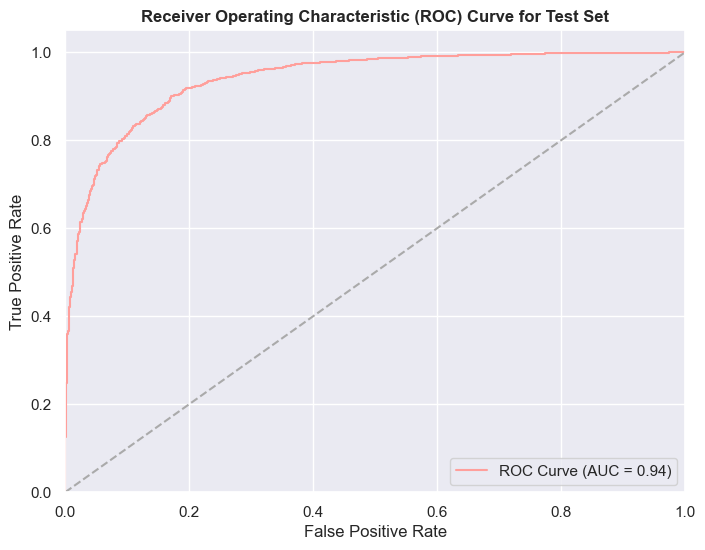

In [19]:
sns.set_theme(style="darkgrid")
roc(X_resampled, y_resampled)

In [76]:
data_prob = data = pd.read_csv(file_path + '/Bank_Customer_Churn_Prediction.csv')

In [77]:
data_prob.drop(columns='customer_id',axis=1,inplace=True)
data_prob.drop(columns='churn',axis=1,inplace=True)
data_prob['country'] = data_prob['country'].map({'France': 0, 'Spain' : 1,'Germany':2})
data_prob['gender'] = data_prob['gender'].map({'Male': 0, 'Female' : 1})
data_prob['balance'] = data_prob['balance'].astype('int64')
data_prob['estimated_salary'] = data_prob['estimated_salary'].astype('int64')


In [78]:
data_prob.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,1,42,2,0,1,1,1,101348
1,608,1,1,41,1,83807,1,0,1,112542
2,502,0,1,42,8,159660,3,1,0,113931
3,699,0,1,39,1,0,2,0,0,93826
4,850,1,1,43,2,125510,1,1,1,79084


In [79]:
probabilities = model_xgb.predict_proba(data_prob)[:, 1]  # Probabilidad de clase positiva (fuga)
# Define los umbrales para cada categoría de riesgo
umbral_alto = 0.75
umbral_medio = 0.40

# Asigna a cada cliente a una categoría de riesgo
probabilidades = []
categorias_riesgo = []
for probabilidad in probabilities:
    probabilidades.append(probabilidad)
    if probabilidad > umbral_alto:
        categorias_riesgo.append('High Risk')
    elif probabilidad > umbral_medio:
        categorias_riesgo.append('Medium Risk')
    else:
        categorias_riesgo.append('Low Risk')

data_prob = data = pd.read_csv(file_path + '/Bank_Customer_Churn_Prediction.csv')
# Agrega las categorías de riesgo al conjunto de datos
data_prob['churn_probability'] = probabilidades
data_prob['churn risk'] = categorias_riesgo

In [80]:
data_prob.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,churn_probability,churn risk
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.340052,Low Risk
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.639270,Medium Risk
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.826593,High Risk
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.484471,Medium Risk
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.290055,Low Risk


In [81]:
data_prob.tail()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,churn_probability,churn risk
9995,15606229,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0.264244,Low Risk
9996,15569892,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0.370884,Low Risk
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0.478528,Medium Risk
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0.117475,Low Risk
9999,15628319,792,France,Female,28,4,130142.79,1,1,0,38190.78,0,0.370884,Low Risk


In [82]:
data_prob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        10000 non-null  int64  
 1   credit_score       10000 non-null  int64  
 2   country            10000 non-null  object 
 3   gender             10000 non-null  object 
 4   age                10000 non-null  int64  
 5   tenure             10000 non-null  int64  
 6   balance            10000 non-null  float64
 7   products_number    10000 non-null  int64  
 8   credit_card        10000 non-null  int64  
 9   active_member      10000 non-null  int64  
 10  estimated_salary   10000 non-null  float64
 11  churn              10000 non-null  int64  
 12  churn_probability  10000 non-null  float32
 13  churn risk         10000 non-null  object 
dtypes: float32(1), float64(2), int64(8), object(3)
memory usage: 1.0+ MB


In [83]:
import random
import datetime

num_filas = len(data_prob)
fechas_aleatorias = [datetime.datetime(2024, 3, random.randint(1, 31)) for _ in range(num_filas)]
data_prob['date'] = fechas_aleatorias

In [84]:
data_prob.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,churn_probability,churn risk,date
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.340052,Low Risk,2024-03-11
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.639270,Medium Risk,2024-03-30
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.826593,High Risk,2024-03-28
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.484471,Medium Risk,2024-03-22
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.290055,Low Risk,2024-03-26


In [85]:
data_prob.to_csv(file_path+'final_data.csv')

In [86]:
clientes = data_prob.loc[data_prob['churn risk'] == 'High Risk']
clientes.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,churn_probability,churn risk,date
2,15619304,502,France,Female,42,8,159660.8,3,1,0,113931.57,1,0.826593,High Risk,2024-03-28
30,15589475,591,Spain,Female,39,3,0.0,3,1,0,140469.38,1,0.835567,High Risk,2024-03-10
88,15622897,646,France,Female,46,4,0.0,3,1,0,93251.42,1,0.796433,High Risk,2024-03-16
90,15757535,647,Spain,Female,44,5,0.0,3,1,1,174205.22,1,0.835567,High Risk,2024-03-12
238,15794056,668,France,Female,46,2,0.0,3,1,0,89048.46,1,0.796433,High Risk,2024-03-17
